In [2]:
import numpy as np
from PIL import Image
import csv
import glob
from imagery_psychophysics.src.object_map import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
##read in many masks
object_map_collection = '/musc.repo/Data/shared/my_labeled_images/labeled_image_maps/*.png'
object_map_file_list = glob.glob(object_map_collection)
num_masks = 10
dl = dead_leaves(object_map_file_list[0:num_masks], image_shape=(64,64))


In [4]:
##find indices of a matrix nbd. defined by a point and a radius
def pairwise_less_than(ref_point, all_other_points, radius):
    return nonzero(np.sqrt(np.sum((ref_point - all_other_points)**2,axis=2)) <= radius)

rp = array([5,5])
foo,baz = meshgrid(range(10), range(10))

biz,bop = pairwise_less_than(rp, dstack([foo,baz]), radius = 2)
print biz
print bop


[3 4 4 4 5 5 5 5 5 6 6 6 7]
[5 4 5 6 3 4 5 6 7 4 5 6 5]


In [5]:
#create set of overlapping circular probes of fixed radius
probe_rad = 6 ##radius in pixels
probe_step = 3 ##spacing between probes
nbd_rad = 5 ##nbd radius in units of probe size 
nbd_step = 1##nbd step in units of probe size

image_size = int(np.sqrt(dl.npix))

##generate explicit indices for all pixels in an object map
pixel_index_i, pixel_index_j = meshgrid(range(image_size), range(image_size))
num_probe_rows = len(arange(0,image_size, probe_step))
num_probes = num_probe_rows**2
PROBES = zeros((image_size, image_size, num_probe_rows,num_probe_rows))
for probe_index_i, probe_location_i in enumerate(arange(0,image_size,probe_step)):
    for probe_index_j, probe_location_j in enumerate(arange(0,image_size,probe_step)):
        pix_i, pix_j = pairwise_less_than(array([probe_location_i, probe_location_j]), dstack([pixel_index_i, pixel_index_j]), probe_rad)
        PROBES[pix_i,pix_j,probe_index_i,probe_index_j] = 1



print 'probe shape: %s' %(PROBES.shape, )
##(pixels_i, pixels_j, probes_i, probes_j)

probe shape: (64, 64, 22, 22)


In [15]:
22**2

484

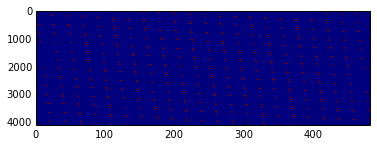

In [6]:
imshow(PROBES.reshape(dl.npix,num_probes),aspect=.04)

In [7]:
##get responses across probes for each
RESPONSES = dl.bom.T.dot(PROBES.reshape(dl.npix,num_probes))  ##shape = num_objects x num_probes
RESPONSES = array(map(lambda x: np.sum(RESPONSES[slice(x[0],x[1]), :]>0, axis=0), dl.map_list))

##reshape for alignment with "PROBES"
RESPONSES = RESPONSES.reshape(RESPONSES.shape[0], np.sqrt(num_probes),np.sqrt(num_probes))

<matplotlib.colorbar.Colorbar instance at 0x5332950>

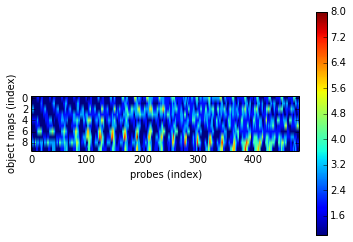

In [8]:
imshow(RESPONSES.reshape(RESPONSES.shape[0], num_probes), aspect = 10)
xlabel('probes (index)')
ylabel('object maps (index)')
colorbar()

In [9]:
RESPONSES.shape

(10, 22, 22)

all responses for this map
[[1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 2 2 2 2 2 1 1 1 1 1 1 1 1 2 2]
 [1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 3 3 3 2 2]
 [1 1 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 3 2 2]
 [1 1 1 1 1 1 1 1 1 1 2 2 2 2 3 3 4 4 4 4 3 2]
 [1 1 1 1 1 1 1 1 1 1 1 1 2 2 4 4 4 4 4 4 2 2]
 [2 2 2 2 1 1 1 2 2 2 1 1 1 1 3 3 3 4 4 4 3 2]
 [2 2 2 2 2 3 2 2 2 2 2 2 1 2 4 4 5 6 5 5 4 3]
 [2 2 2 2 2 3 2 2 2 3 3 3 2 3 5 5 6 7 5 5 5 2]
 [2 2 2 2 2 3 2 2 3 3 3 3 2 3 4 5 6 7 6 4 3 2]
 [1 1 2 2 3 4 3 2 5 4 4 3 2 2 4 6 6 5 6 4 3 3]
 [1 1 2 2 3 4 4 4 5 5 5 3 2 2 3 5 6 5 5 4 3 3]
 [1 1 3 4 4 5 4 5 6 5 4 2 2 1 1 3 4 4 4 3 2 2]
 [2 3 3 4 4 4 4 5 5 5 4 2 2 2 2 2 3 3 4 2 2 2]
 [2 3 3 4 4 4 4 4 3 4 3 2 2 2 2 2 2 2 1 1 1 1]
 [3 3 3 3 3 2 3 3 3 3 2 2 2 2 2 2 2 2 1 1 1 1]
 [3 3 4 3 1 2 3 3 3 2 2 1 1 2 2 1 1 1 1 1 1 1]
 [2 3 3 3 2 2 2 2 3 1 1 1 1 1 1 1

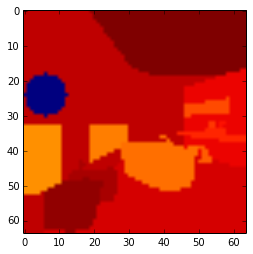

In [10]:
##check to make sure the responses are correct
map_dx = 9
print 'all responses for this map' 
print RESPONSES[map_dx, :].T
probe_index_i = 2
probe_index_j = 8
print 'response for this one probe: %d' %(RESPONSES[map_dx, probe_index_i, probe_index_j])
im0 = dl.spawn_object_map(map_dx)
imshow(im0.map_as_array-PROBES[:,:,probe_index_i, probe_index_j]*50)


In [11]:
##iterate over nbds and measure dispersion

probe_index_i, probe_index_j = meshgrid(range(num_probe_rows), range(num_probe_rows))
num_nbd_rows = len(arange(0,num_probe_rows, nbd_step))
num_nbd = num_nbd_rows**2
DISPERSION = np.zeros((num_masks, num_nbd_rows, num_nbd_rows))
NUMOBJECTS = np.zeros((num_masks, num_nbd_rows, num_nbd_rows))
for nbd_index_i in arange(0,num_probe_rows, nbd_step):
    for nbd_index_j in arange(0,num_probe_rows, nbd_step):
        id_i, id_j = pairwise_less_than(array([nbd_index_i, nbd_index_j]), dstack([probe_index_i, probe_index_j]), nbd_rad)
        nbd_filter = np.sum(PROBES[:,:,id_i, id_j],axis=2)>0
        norm_const = float(len(id_i))
        DISPERSION[:, nbd_index_i, nbd_index_j] = 1-np.sum(array([(np.sum(RESPONSES[:,id_i, id_j]==ii, axis=1)/norm_const)**2 for ii in np.unique(RESPONSES[:,id_i, id_j])]), axis=0)
        NUMOBJECTS[:, nbd_index_i, nbd_index_j] = np.array(map(lambda x: len(np.unique(dl.spawn_object_map(x).map_as_array[pixel_index_i[nbd_filter>0],pixel_index_j[nbd_filter>0]])), range(num_masks)))


##



In [12]:
DISPERSION.shape
## = (number_of_maps x number_of_nbd_rows x number_of_nbd_cols)

(10, 22, 22)

In [19]:
DISPERSION[:,:, 10]

array([[ 0.58128544,  0.59371901,  0.59033203,  0.58172265,  0.5784375 ,
         0.62825789,  0.68129858,  0.7248895 ,  0.75201951,  0.75659198,
         0.75750648,  0.74409389,  0.72153635,  0.70507545,  0.70507545,
         0.68099375,  0.64167048,  0.59125   ,  0.55920435,  0.54638672,
         0.53487603,  0.54725898],
       [ 0.48487713,  0.48661157,  0.48779297,  0.4788891 ,  0.4746875 ,
         0.47797592,  0.49077884,  0.5337601 ,  0.59228776,  0.63344002,
         0.66361835,  0.66971498,  0.67093431,  0.62277092,  0.59533608,
         0.59777473,  0.61515013,  0.6053125 ,  0.60424095,  0.57861328,
         0.54347107,  0.45463138],
       [ 0.20132325,  0.36694215,  0.4765625 ,  0.54644399,  0.5565625 ,
         0.62520957,  0.66270386,  0.69745466,  0.70050297,  0.69135802,
         0.69775949,  0.70873342,  0.73129096,  0.74531321,  0.76878525,
         0.78067368,  0.76299345,  0.7553125 ,  0.75473822,  0.74902344,
         0.75570248,  0.75897921],
       [ 0.55671078

dispersion for nbd (15, 10) = 0.850480
number of objects for nbd (15, 10) = 11.000000
total number of object in entire map: 18


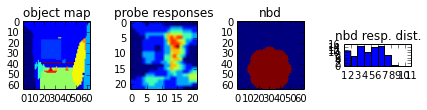

In [24]:
##check to make sure the responses are correct
##when best nbd has been found, run this to visualize everything
map_dx = 7
im0 = dl.spawn_object_map(map_dx)

##let's say we've determined that these are the i,j coordinates of the nbd with the highest dispersion
nbd_index_i = 15
nbd_index_j = 10
##then id_i, id_j are the indices for the probes that live in that nbd
id_i, id_j = pairwise_less_than(array([nbd_index_i, nbd_index_j]), dstack([probe_index_i, probe_index_j]), nbd_rad)

##this gives you a picture of the nbd
nbd_filter0 = np.sum(PROBES[:,:,id_i, id_j],axis=2)>0
##^^to save the probes, you want this: PROBES[:,:,id_i, id_j]

subplot(1,4,1)
title('object map')
imshow(im0.map_as_array)
subplot(1,4,2)
title('probe responses')
imshow(RESPONSES[map_dx, :, :])
subplot(1,4,3)
title('nbd')
imshow(nbd_filter0)
print 'dispersion for nbd %s = %f' %((nbd_index_i, nbd_index_j), DISPERSION[map_dx, nbd_index_i, nbd_index_j])
print 'number of objects for nbd %s = %f' %((nbd_index_i, nbd_index_j), NUMOBJECTS[map_dx, nbd_index_i, nbd_index_j])
print 'total number of object in entire map: %d' %(im0.count_myself())
subplot(1,4,4, aspect = .2)
title('nbd resp. dist.')
hist(RESPONSES[map_dx,id_i, id_j],range(1,int(NUMOBJECTS[map_dx, nbd_index_i, nbd_index_j])+1))
xticks(np.arange(1,int(NUMOBJECTS[map_dx, nbd_index_i, nbd_index_j])+1, 1))
tight_layout()


